# Preamble

In [11]:
# %%sh
# sudo apt update
# sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng
# mkdir out

In [12]:
import copy
import sys
from typing import *

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb

sns.set_context("paper", font_scale=1.5)
matplotlib.rc("font", family="serif", serif=["CMU Serif"])
matplotlib.rc("text", usetex=True)
# matplotlib.rc("font", family="sans-serif"); matplotlib.rc("text", usetex=False)
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

api = wandb.Api()

In [6]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    llama_eviction_bug_commits = {"12d9e3b7228c1e166f614f5acdd8a205e27236a4", "3f4fd0fa4f4b6bd119945c3e5f09028c1e569ca3"}
    if "count" in run.summary:
        task = run.config["task"]["name"]
        model = run.config["model"].split("/")[1].replace("-hf", "").replace("-v0.1", "").lower()
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        if sparsity["name"] == "eviction" and "llama" in model and run.commit in llama_eviction_bug_commits:
            return
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            experiment=run.config["name"],
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            wikitext_bugfix=run.config["code_changes"].get("forced-sample-no-specials", False),
            model=model,
            # n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            n_kv_heads=mc.get("num_key_value_heads", mc["num_attention_heads"]) * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
            id=run.id,
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_kv_heads"]

def add_dense_as_sparse(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'name' string (not k, etc).
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g["name"]=="dense"]
        if len(g_dense) != 1:
            print(f"Warning: multiple dense results found for {g.task.iloc[0]}, {g.model.iloc[0]}", file=sys.stderr)
        return (g.groupby("name")
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(name=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)

palette = sns.color_palette()
name_to_hue = dict(dense=palette[4], ann=palette[0], eviction=palette[2], local=palette[3], sparse_v=palette[1])
name_to_label = dict(ann="SparQ Attention", eviction="H$_2$O", local="LM-Infinite", sparse_v="FlexGen (16-bit)")
name_to_marker = dict(dense=".", ann="o", eviction="X", local="^", sparse_v="P")

# Arithmetic intensity

In [2]:
def arithmetic_intensity(rho: float, g: float, B: int) -> float:
    return (6 * B + rho * g * B) / (6 + rho * B)

dfi = pd.DataFrame.from_dict(
    [dict(rho=rho, B=B, g=g, ai=arithmetic_intensity(rho=rho, g=g, B=B))
     for rho in 2**np.arange(-6, 6.01, 1)
     for B in (2**np.arange(0, 10.01, .25)).astype(np.int32)
     for g in [1, 8]]
)

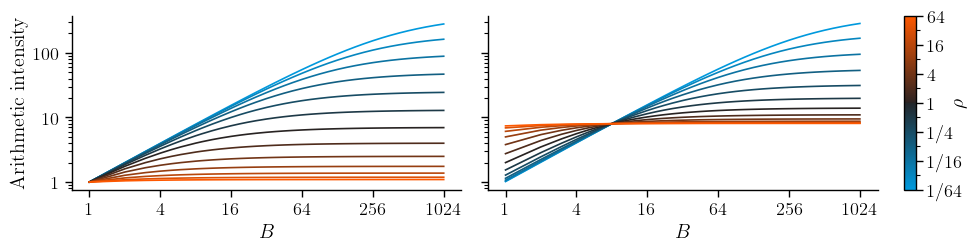

In [4]:
# _, axs = plt.subplots(1, 3, figsize=(10, 3.5), width_ratios=(1, 1, .05))
fig = plt.figure(figsize=(10, 2.75))
grid = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[1, 1, .03])
axs = []
for i in range(3):
    axs.append(fig.add_subplot(grid[i], sharey=axs[0] if i == 1 else None))
norm = matplotlib.colors.SymLogNorm(vmin=dfi.rho.min(), vmax=dfi.rho.max(), linthresh=1e-5, base=2)
palette = sns.diverging_palette(240, 20, s=100, l=60, center="dark", as_cmap=True)
for ax, g in zip(axs, [1, 8]):
    sns.lineplot(data=dfi[dfi.g == g], y="ai", x="B", hue="rho", hue_norm=norm, palette=palette, ax=ax)
    ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([1, 4, 16, 64, 256, 1024])
    ax.set_xlabel("$B$")
    sns.despine(ax=ax)
axs[0].set_yscale("log")
axs[0].yaxis.set_major_formatter("{x:.0f}")
axs[0].set_ylabel("Arithmetic intensity")
axs[1].tick_params(axis="y", which="both", labelleft=False)
axs[1].set_ylabel("")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette, norm=norm), cax=axs[-1])
cbar.set_label(r"$\rho$", labelpad=-10)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"1/{1/x:.0f}" if x < 1 else f"{x:.0f}")
cbar.ax.set_yticks([1/64, 1/16, 1/4, 1, 4, 16, 64])
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig(f"out/arithmetic_intensity.pdf", bbox_inches="tight")

# Results

In [7]:
df = (
    pd.concat([
        # General
        load_sweep("RMOE-68-workshop-sweep").pipe(lambda d: d[d.model!="llama-2-13b"]),
        load_sweep("RMOE-68-lower-r"),
        load_sweep("RMOE-68-llama-7b-reruns-with-fix"),
        load_sweep("RMOE-71-ablations-main-sweep-top-k-sparse-attention"),
        # Llama 13B
        load_sweep("RMOE-77-larger-models-a100"),
        load_sweep("RMOE-77-larger-models-a100-rerun-wikitext"),
        load_sweep("RMOE-77-larger-models-a100-lower-r"),
        # Mistral
        load_sweep("RMOE-74-mistral-full-sweep"),
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[(d.task != "wikitext_bpc") | (~d.model.isin(["llama-2-13b", "llama-2-7b"])) | d.wikitext_bugfix])
    .pipe(lambda d: d[(d.name != "ann") | (d.k == 128)])
    .pipe(lambda d: d[d["rank"] != 12])
    .pipe(lambda d: d[(~d.name.isin(["eviction", "local"])) | (d.k >= 192)])
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr", "experiment", "id"]]
)

/tmp/ipykernel_86153/1479067203.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([


/tmp/ipykernel_86153/1499815329.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(name=gg.name)]))
/tmp/ipykernel_86153/1499815329.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)


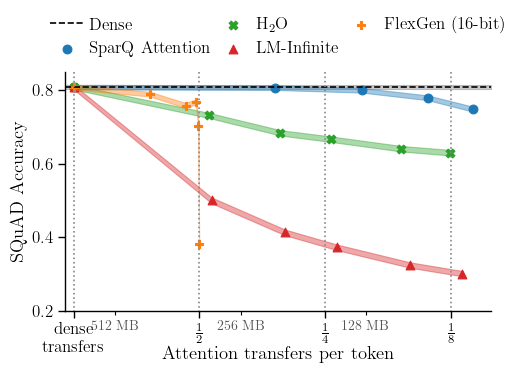

In [27]:
def show_tradeoff(model: str, task: str, title: bool, xlabel: bool, ylabel: bool, model_label: bool,
                  vlines: List[float], vlineslabel: bool,
                  ax: matplotlib.axes.Axes) -> None:
    g = add_dense_as_sparse(df[(df.model == model)&(df.task == task)])
    if not len(g[g.name=="dense"]):
        print(f"Cannot show {model}, {task}, as there is no dense baseline")
        return
    dense = g[g.name=="dense"].iloc[0]
    rmin, rmax = dict(
        squad=(.5, 1.05),
        cnn_dailymail=(.5, 1.05),
        triviaqa=(.5, 1.05),
        wikitext_bpc=(1.25, 1/1.025),
        repetition=(0, 1.1),
    )[task]
    score_min, score_max = dense.score * rmin, dense.score * rmax
    # transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 8.5
    transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 10
    lo = dense.score - dense.score_stderr
    hi = dense.score + dense.score_stderr
    ax.fill_between([transfers_min, transfers_max], [lo, lo], [hi, hi], color="k", alpha=.2)
    ax.hlines(dense.score, transfers_min, transfers_max, "k", linestyles="--", label="Dense")
    for ratio in vlines:
        ax.vlines(dense.transfers / ratio, 0, g.score.max() * 2, "k", linestyles=":", color="#888")

    for name, hue in name_to_hue.items():
        if name != "dense":
            d = g[g.name == name].sort_values("transfers")
            ax.fill_between(d.transfers, d.score - d.score_stderr, d.score + d.score_stderr, color=hue, alpha=.4)
            ax.scatter(d.transfers, d.score, color=hue, label=name_to_label[name], marker=name_to_marker[name], s=40)
    ax.set_xscale("log", base=2)
    ax.set_xlim((transfers_min, transfers_max))
    ax.set_ylim((score_min, score_max))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, steps=[1,2,3,5,10]))
    if vlineslabel:
        assert vlines[0] == 1
        ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([dense.transfers / ratio for ratio in vlines]))
        ax.tick_params(axis="x", which="minor", bottom=True, labelbottom=True, labelsize=10, labelcolor="#555")
        labels = ["dense\ntransfers"] + [f"$\\frac{{1}}{{{ratio}}}$" for ratio in vlines[1:]]
        ax.xaxis.set_major_formatter(lambda _, n: labels[n])
        ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=2))
        ax.xaxis.set_minor_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    else:
        ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    if title:
        ax.set_title(model.capitalize().replace("b", "B").replace("-", " "), pad=12)
    if xlabel:
        ax.set_xlabel("Attention transfers per token")
    if model_label:
        ax.annotate(model, [transfers_min, score_min],
                    xytext=(5, 5), textcoords="offset points", va="bottom", ha="left", fontsize=12, alpha=.75)
    if ylabel:
        ax.set_ylabel(dict(squad="SQuAD Accuracy", cnn_dailymail="CNN/DailyMail ROUGE-L", triviaqa="TriviaQA Accuracy",
                           wikitext_bpc="WikiText-103 BPC", repetition="Repetition match length")[task])
    sns.despine(ax=ax)

sns.set_context("paper", font_scale=1.4)
plt.figure(figsize=(5.5, 3.1))
ax = plt.gca()
show_tradeoff("llama-2-13b", "squad", title=False, xlabel=True, ylabel=True, model_label=False, vlines=[1, 2, 4, 8], vlineslabel=True, ax=ax)
# ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")
# ax.legend(frameon=False, ncols=3, bbox_to_anchor=(0.0, -0.38, 1.0, 0.1), loc="upper center", handletextpad=0.3, columnspacing=0.3)
ax.legend(frameon=False, ncols=3, bbox_to_anchor=(0.0, 1.0, 1.0, 0.1), loc="lower center", handletextpad=0.3, columnspacing=0.3)
ax.set_ylim((0.2, 0.85))
ax.set_xlabel(ax.get_xlabel(), labelpad=-6)
plt.savefig(f"out/tradeoff_llama_squad.pdf", bbox_inches="tight")